In [1]:
import torch
import torch.nn as nn
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
#from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob


from tqdm import tqdm

from torchvision import transforms

from utils import visualize, plot_data
from scipy.io import loadmat

from loss.ot_loss import OT_Loss

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
path = '/mnt/home/hheat/USERDIR/counting-bench/data'
train_images = path + '/images'
test_images = path + '/test_images/images'
anno = path + '/annotation'
density_maps = path + '/dmaps'

LOG_PARA = 1000
crop_size = 1024

In [3]:
def get_train_transforms():
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.Resize(360,640,interpolation=2),
            #A.RandomSizedCrop(min_max_height=(409, 512), height=409, width=512, p=1.0),
            #A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=1.0),
        ],
        #additional_targets={'image': 'image','image1': 'image'}
        #keypoint_params = A.KeypointParams(format='xy')
)

def get_train_image_only_transforms():
    return A.Compose(
        [
            #A.Resize(360,640),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.Blur(blur_limit=3,p=0.2),
            A.Normalize(p=1.0,max_pixel_value=1.0),
            ToTensorV2(p=1.0),
        ],
        additional_targets={'image': 'image'}
    )

def get_valid_trainsforms():
    return A.Compose(
        [
            #A.Resize(360,640,interpolation=2),
            A.Normalize(p=1.0,max_pixel_value=1.0),
            ToTensorV2(p=1.0),
        ]
    )

# mean = torch.tensor([0.4939, 0.4794, 0.4583])
# std = torch.tensor([0.2177, 0.2134, 0.2144])

def denormalize(img):
    img = img * std[...,None,None] + mean[...,None,None]
    img = img.permute(1,2,0).cpu().numpy()
    return img

In [4]:
dis_map = gen_discrete_map(1528,2720,gt_points[0])

NameError: name 'gen_discrete_map' is not defined

In [55]:
dis_map = dis_map.reshape([191,8,340,8]).sum(axis=(1,3))

In [56]:
dis_map.sum()

102.0

In [48]:
1528 / 8

191.0

In [42]:
cv2.resize(dis_map,(2720,1520)).sum()

101.33555

In [4]:
def gen_discrete_map(im_height, im_width, points):
    """
        func: generate the discrete map.
        points: [num_gt, 2], for each row: [width, height]
        """
    discrete_map = np.zeros([im_height, im_width], dtype=np.float32)
    h, w = discrete_map.shape[:2]
    num_gt = points.shape[0]
    if num_gt == 0:
        return discrete_map
    
    # fast create discrete map
    points_np = np.array(points).round().astype(int)
    p_h = np.minimum(points_np[:, 1], np.array([h-1]*num_gt).astype(int))
    p_w = np.minimum(points_np[:, 0], np.array([w-1]*num_gt).astype(int))
    p_index = torch.from_numpy(p_h* im_width + p_w)
    discrete_map = torch.zeros(im_width * im_height).scatter_add_(0, index=p_index, src=torch.ones(im_width*im_height)).view(im_height, im_width).numpy()

    ''' slow method
    for p in points:
        p = np.round(p).astype(int)
        p[0], p[1] = min(h - 1, p[1]), min(w - 1, p[0])
        discrete_map[p[0], p[1]] += 1
    '''
    assert np.sum(discrete_map) == num_gt
    return discrete_map

In [5]:
def gen_discrete_map(im_height, im_width, points):
    """
        func: generate the discrete map.
        points: [num_gt, 2], for each row: [width, height]
        """
    discrete_map = np.zeros([im_height, im_width], dtype=np.float32)
    h, w = discrete_map.shape[:2]
    num_gt = points.shape[0]
    if num_gt == 0:
        return discrete_map
    
    # fast create discrete map
    points_np = np.array(points).round().astype(int)
    p_h = np.minimum(points_np[:, 1], np.array([h-1]*num_gt).astype(int))
    p_w = np.minimum(points_np[:, 0], np.array([w-1]*num_gt).astype(int))
    p_index = torch.from_numpy(p_h* im_width + p_w)
    discrete_map = torch.zeros(im_width * im_height).scatter_add_(0, index=p_index, src=torch.ones(im_width*im_height)).view(im_height, im_width).numpy()

    ''' slow method
    for p in points:
        p = np.round(p).astype(int)
        p[0], p[1] = min(h - 1, p[1]), min(w - 1, p[0])
        discrete_map[p[0], p[1]] += 1
    '''
    assert np.sum(discrete_map) == num_gt
    return discrete_map

In [5]:
class Counting_Dataset(Dataset):
    def __init__(self,path,image_fnames,dmap_folder,gt_folder=None,transforms=None,mosaic=False,downsample=4):
        '''
            path: root path 
            image_fnames: path of images
            dmap_folder: density map folder, eg: /dmap
            gt_folder: gt folder, currently set to visdrone xml format, modify _get_gt_data() if needed
            transforms: iteratable, can be tuple / list ... etc
            mosaic: mix up image and density map to form a new image, set to false by default
            downsample: resize dmap
        '''
        super().__init__()
        self.path = path
        self.image_fnames = image_fnames
        self.dmap_folder = path + dmap_folder
        self.transforms = transforms
        self.mosaic = mosaic
        self.downsample = downsample
        self.gt_folder = gt_folder # test purpose
        
    def __len__(self):
        return len(self.image_fnames)
    
    def __getitem__(self,idx):
        image_id = self.image_fnames[idx]
        
        if self.mosaic and random.randint(0,1) < 0.5:
            image, density_map, gt_points = self._load_mosaic_image_and_density_map(idx)
        else:
            image, density_map, gt_points = self._load_image_and_density_map(idx)
        
        h,w = image.shape[0]//self.downsample, image.shape[1]//self.downsample
        image = cv2.resize(image,(w, h))
        density_map = cv2.resize(density_map,(w//(self.downsample*2),h//(self.downsample*2)))#,interpolation=cv2.INTER_NEAREST)
        
        # Warning: doesn't work for cutout, uncommet transform and make fix code to enable cutout
        # Reason: cutout doesn't apply to mask, so mask must be image. check 01a bottom for code
        if self.transforms:
            for tfms in self.transforms:
                aug = tfms(**{
                    'image': image,
                    'mask': density_map,
                    #'keypoints': gt_points
                })
                #image, density_map, gt_points = aug['image'], aug['mask'], aug['keypoints']
                image, density_map = aug['image'], aug['mask'] # issue with previous keypoints (albumentation?)
        
        
        return image, density_map, image_id, gt_points
        
    
    def _get_dmap_name(self,fn):
        mask_name = fn.split('/')[-1].split('.')[0]
        mask_path = self.dmap_folder + '/' + mask_name + '.npy'
        return mask_path
    
    def _load_image_and_density_map(self,idx):
        image_fname = self.image_fnames[idx]
        dmap_fname = self._get_dmap_name(image_fname)
        image = cv2.imread(image_fname)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image/255.
        d_map = np.load(dmap_fname,allow_pickle=True)
        
        #sanity check gt
        _, points = self._get_gt_data(idx)
        # end sanity check
        
        return image, d_map, points
    
    def _load_mosaic_image_and_density_map(self,idx):
        image_1, dmap_1, points_1 = self._load_image_and_density_map(idx)
        while True:
            idx_2 = random.randint(0,len(self.image_fnames)-1)
            if idx != idx_2:
                break
        image_2, dmap_2, points_2 = self._load_image_and_density_map(idx_2)
        
        imsize = min(*image_1.shape[:2])
        xc,yc = [int(random.uniform(imsize*0.4,imsize*0.6)) for _ in range(2)]
        h,w = image_1.shape[0], image_1.shape[1]

        pos = random.randint(0,1)
        if pos == 0: #top left
            x1a,y1a,x2a,y2a = 0,0,xc,yc # img_1
            x1b,y1b,x2b,y2b = w-xc,h-yc,w,h # img_2
        elif pos == 1: # top right
            x1a,y1a,x2a,y2a = w-xc,0,w,yc
            x1b,y1b,x2b,y2b = 0,h-yc,xc,h
        elif pos == 2: # bottom left
            x1a,y1a,x2a,y2a = 0,h-yc,xc,h
            x1b,y1b,x2b,y2b = w-xc,0,w,yc
        elif pos == 3: # bottom right
            x1a,y1a,x2a,y2a = w-xc,h-yc,w,h
            x1b,y1b,x2b,y2b = 0,0,xc,yc
        
        new_image = image_1.copy()
        new_dmap = dmap_1.copy()
        new_image[y1a:y2a,x1a:x2a] = image_2[y1b:y2b,x1b:x2b]
        new_dmap[y1a:y2a,x1a:x2a] = dmap_2[y1b:y2b,x1b:x2b]
        
        #TODO: sanity check to see generate gt
        
        new_gt_points = self._get_mixed_gt_points(points_1,points_2,(x1a,y1a,x2a,y2a),(x1b,y1b,x2b,y2b),(h,w))
        
        return new_image, new_dmap, new_gt_points
    
    '''
    The follow section blocks are for sanity check 
    to compare dmap.sum() with gt points
    remove if needed
    '''
    def _get_mixed_gt_points(self,points_1,points_2,img_1_loc, img_2_loc,img_shape):
#         fn_1, points_1 = self._get_gt_data(idx_1)
#         fn_2, points_2 = self._get_gt_data(idx_2)
        x1a,y1a,x2a,y2a = img_1_loc
        x1b,y1b,x2b,y2b = img_2_loc
        h,w = img_shape
        
        result_boxes = []
        result_boxes.append(points_2)
        result_boxes = np.concatenate(result_boxes,0)
        padw = x1a-x1b
        pady = y1a-y1b

        result_boxes[:,0] += padw
        result_boxes[:,1] += pady

        np.clip(result_boxes[:,0],0,w,out=result_boxes[:,0])
        np.clip(result_boxes[:,1],0,h,out=result_boxes[:,1])
        result_boxes = result_boxes.astype(np.int32)

        result_boxes = result_boxes[np.where(result_boxes[:,0] * result_boxes[:,1] > 0)]
        result_boxes = result_boxes[np.where(result_boxes[:,0] < w)]
        result_boxes = result_boxes[np.where(result_boxes[:,1] < h)]
        
        boxes = []
        for (x,y) in points_1:
            if x >= x1a and x <= x2a and y >= y1a and y <= y2a:
                continue
            else:
                boxes.append((x,y))
        if len(boxes) == 0:
            return result_boxes
        return np.concatenate((boxes, result_boxes),axis=0)
    
    def _get_gt_data(self,idx):
        if not self.gt_folder:
            return (None,0)
        fn = self.image_fnames[idx]
        anno_path = self.path + self.gt_folder + '/' + fn.split('/')[-1].split('.')[0] + '.mat'
        test_data = loadmat(anno_path)
        points = test_data['annotation'].astype(int)
        return fn, points
    
    
    
# ADD LOG_PARA to density map

class Crop_Dataset(Counting_Dataset):
    def __init__(self,path,image_fnames,dmap_folder,gt_folder=None,transforms=None,mosaic=False,downsample=4,crop_size=crop_size,method='train'):
        super().__init__(path,image_fnames,dmap_folder,gt_folder,transforms,mosaic,downsample)
        self.crop_size = crop_size
        if method not in ['train','valid']:
            raise Exception('Not Implement')
        self.method = method
    
    def __getitem__(self,idx):
        fn = self.image_fnames[idx]
        
        image,density_map,gt_points = self._load_image_and_density_map(idx)
        h,w = image.shape[0], image.shape[1]
        #image = cv2.resize(image,(w, h))
        
        
        if self.method == 'train':
            #h,w = image.shape[:2]
            i,j = self._random_crop(h,w,self.crop_size,self.crop_size)
            image = image[i:i+self.crop_size,j:j+self.crop_size]
            density_map = density_map[i:i+self.crop_size,j:j+self.crop_size]
            
            h,w = image.shape[0], image.shape[1]
            
            gt_points = gt_points - [j,i]
            mask = (gt_points[:,0] >=0 ) * (gt_points[:,0] <= self.crop_size) * (gt_points[:,1]>=0) * (gt_points[:,1]<=self.crop_size)
            gt_points = gt_points[mask]
            #density_map = cv2.resize(density_map,(self.crop_size//self.downsample,self.crop_size//self.downsample))
            if len(gt_points) == 0:
                gt_points = np.empty([0, 2])
            
        elif self.method == 'valid':
            h = 1528
            
        #dm_count
        gt_discrete = gen_discrete_map(h,w,gt_points)
        final_w = w // self.downsample
        final_h = h // self.downsample
        gt_discrete = gt_discrete.reshape([final_h,self.downsample,final_w,self.downsample]).sum(axis=(1,3))
        assert np.sum(gt_discrete) == len(gt_points)
        
        if self.transforms:
            for tfms in self.transforms:
                aug = tfms(**{
                    'image': image,
                    'mask': gt_discrete,
                    #'keypoints': gt_points
                })
                #image, density_map, gt_points = aug['image'], aug['mask'], aug['keypoints']
                image, gt_discrete = aug['image'], aug['mask'] # issue with previous keypoints (albumentation?)
        return image, gt_discrete, fn, torch.from_numpy(gt_points).float()
    
    def _random_crop(self, im_h, im_w, crop_h, crop_w):
        res_h = im_h - crop_h
        res_w = im_w - crop_w
        i = random.randint(0, res_h)
        j = random.randint(0, res_w)
        return i, j

In [6]:
train_fp = glob(train_images + '/*.jpg')
test_fp = glob(test_images + '/*.jpg')

#split = int(len(train_fp) * 0.8)


train_dataset = Crop_Dataset(path=path,
                             image_fnames=train_fp,dmap_folder='/dmaps',
                             gt_folder='/annotation',
                             transforms=[get_train_transforms(),get_train_image_only_transforms()],
                             downsample=8,crop_size=crop_size
                                )

valid_dataset = Crop_Dataset(path=path,
                             image_fnames=test_fp,dmap_folder='/dmaps',
                             gt_folder='/annotation',
                             transforms=[get_valid_trainsforms()],
                             method='valid',
                             downsample=8
                                )

# Test crop issue?

In [17]:
image, dmap, fn, gt_points = train_dataset[300]

In [18]:
dmap.shape

torch.Size([128, 128])

In [19]:
dmap.sum()

tensor(18.)

In [14]:
len(gt_points)

31

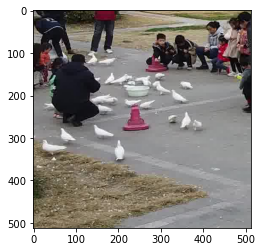

In [154]:
plt.imshow(image)

In [531]:
fn

'/mnt/home/hheat/USERDIR/counting-bench/data/images/11_068.jpg'

In [532]:
count = 0
for i in range(100):
    image, dmap, fn, gt_points = train_dataset[200]
    if len(gt_points) == 0:
        count += 1
count

40

In [533]:
count = 0
for i in range(100):
    image, dmap, fn, gt_points = train_dataset[200]
    if len(gt_points) < 5:
        count += 1
count

80

In [534]:
count = 0
for i in range(100):
    image, dmap, fn, gt_points = train_dataset[200]
    if len(gt_points) < 36:
        count += 1
count

100

In [520]:
count = 0
for i in range(100):
    image, dmap, fn, gt_points = train_dataset[200]
    if len(gt_points) < 36:
        count += 1
count

100

In [521]:
count = 0
for i in range(100):
    image, dmap, fn, gt_points = train_dataset[200]
    if len(gt_points) < 36:
        count += 1
count

100

In [489]:
from PIL import Image

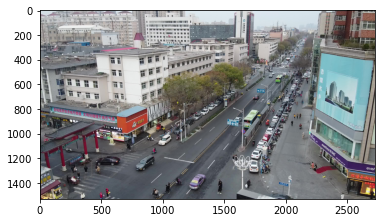

In [530]:
pil_image = Image.open(fn)
plt.imshow(pil_image)

In [529]:
len(loadmat(anno+'/11_068.mat')['annotation'])

64

In [503]:
np.array(pil_image).shape

(1530, 2720, 3)

# Done test crop issue

In [7]:
class TrainGlobalConfig:
    num_workers = 8
    batch_size = 8
    n_epochs = 40 # n_epochs = 40
    lr = 0.0002

    folder = 'test_delete'
    downsample = 8

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = True  # do scheduler.step after optimizer.step
    validation_scheduler = False  # do scheduler.step after validation stage loss

    SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
    scheduler_params = dict(
        max_lr=1e-4,
        #total_steps = len(train_dataset) // 4 * n_epochs, # gradient accumulation
        epochs=n_epochs,
        steps_per_epoch=int(len(train_dataset) / batch_size),
        pct_start=0.2,
        anneal_strategy='cos', 
        final_div_factor=10**5
    )
    
#     SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
#     scheduler_params = dict(
#         mode='min',
#         factor=0.5,
#         patience=1,
#         verbose=False, 
#         threshold=0.0001,
#         threshold_mode='abs',
#         cooldown=0, 
#         min_lr=1e-8,
#         eps=1e-08
#     )

# DM_Count

In [8]:
# Credit: https://github.com/cvlab-stonybrook/DM-Count/blob/master/models.py

import torch.utils.model_zoo as model_zoo
from torch.nn import functional as F

__all__ = ['vgg19']
model_urls = {
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
}

class VGG(nn.Module):
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.reg_layer = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.density_layer = nn.Sequential(nn.Conv2d(128, 1, 1), nn.ReLU())

    def forward(self, x):
        x = self.features(x)
        x = F.upsample_bilinear(x, scale_factor=2)
        x = self.reg_layer(x)
        mu = self.density_layer(x)
        B, C, H, W = mu.size()
        mu_sum = mu.view([B, -1]).sum(1).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        mu_normed = mu / (mu_sum + 1e-6)
        return mu, mu_normed

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfg = {
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512]
}

def vgg19():
    """VGG 19-layer model (configuration "E")
        model pre-trained on ImageNet
    """
    model = VGG(make_layers(cfg['E']))
    model.load_state_dict(model_zoo.load_url(model_urls['vgg19']), strict=False)
    return model

In [9]:
net = vgg19().cuda()

In [10]:
def get_loss(crop_size,downsample,norm_cood=1,device='cuda'):
    ot_loss = OT_Loss(crop_size,downsample,norm_cood,device)
    tv_loss = nn.L1Loss(reduction='none').to(device)
    return ot_loss, tv_loss



def MSELoss(preds,targs):
    return nn.MSELoss()(preds,targs)

def MAELoss(preds,targs):
    return nn.L1Loss()(preds.sum(dim=[-1,-2]), targs)

# Train Loop

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        

In [12]:
import warnings
warnings.filterwarnings("ignore")

#opt_level ='O1' # apex

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'/mnt/home/hheat/USERDIR/counting-bench/model/{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_mae_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        
        #self.model, self.optimizer = amp.initialize(self.model,self.optimizer,opt_level=opt_level) # apex
        self.scaler = torch.cuda.amp.GradScaler()
        
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.ot_loss, self.tv_loss = get_loss(crop_size,config.downsample)
        self.mse = MSELoss
        self.mae = MAELoss
        self.log(f'Fitter prepared. Device is {self.device}')
        
        # self.iters_to_accumulate = 4 # gradient accumulation

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss, mae_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, mse_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, mae_loss: {mae_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            #self.log(f'[RESULT]: Val. Epoch: {self.epoch}, mae_loss: {mae_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=mae_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        #summary_loss = AverageMeter()
        mae_loss = AverageMeter()
        t = time.time()
        for step, (images, density_maps, fns, gt_pts) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        #f'mse_loss: {summary_loss.avg:.5f}, ' + \
                        f'mae_loss: {mae_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                density_maps = density_maps.to(self.device).float()
                
                outputs, _ = self.model(images)
                outputs = F.pad(outputs,(0,0,0,1))
                res = self.mae(outputs,density_maps)
                #res = density_maps[0].sum().item() - torch.sum(outputs).item()
                
                
                mae_loss.update(res,batch_size)
                #summary_loss.update(loss.detach().item(), batch_size)
            if step == 20:
                break

        return mae_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        epoch_summary_loss = AverageMeter()
        epoch_ot_loss = AverageMeter()
        epoch_tv_loss = AverageMeter()
        #epoch_mse_loss = AverageMeter()
        epoch_mae_loss = AverageMeter()
        t = time.time()
        for step, (images, density_maps, fns, gt_pts) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'total_loss: {epoch_summary_loss.avg:.5f}, ' + \
                        f'mae_loss: {epoch_mae_loss.avg:.5f}, ' + \
                        f'ot_loss: {epoch_ot_loss.avg:.5f}, ' + \
                        f'tv_loss: {epoch_tv_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = images.cuda().float()
            batch_size = images.shape[0]
            density_maps = density_maps.to(self.device).float()
            gt_pts = [p.to(self.device) for p in gt_pts]
            gd_count = np.array([len(p) for p in gt_pts], dtype=np.float32)
            gd_count = torch.from_numpy(gd_count).to(self.device)
            
            
            
            self.optimizer.zero_grad()
            
            with torch.cuda.amp.autocast(): #native fp16
                outputs, outputs_normed = self.model(images)
                outputs, outputs_normed = outputs, outputs_normed
                ot_loss, wd, ot_obj_value = self.ot_loss(outputs_normed,outputs,gt_pts)
                ot_loss *= 0.1
                ot_obj_value *= 0.1
                count_loss = self.mae(outputs.squeeze(),gd_count)
                gt_discrete_normed = density_maps / (gd_count[...,None,None,None] + 1e-6)
                tv_loss = (self.tv_loss(outputs_normed,gt_discrete_normed).sum([-1,-2,-3]) * gd_count).mean(0) * 0.01
                loss = ot_loss + count_loss + tv_loss
            self.scaler.scale(loss).backward()
            
            # loss = loss / self.iters_to_accumulate # gradient accumulation
            
#             with amp.scale_loss(loss,self.optimizer) as scaled_loss: # apex
#                 scaled_loss.backward()
            #loss.backward()
            epoch_ot_loss.update(ot_loss.detach().item(),batch_size)
            epoch_tv_loss.update(tv_loss.detach().item(),batch_size)
            epoch_mae_loss.update(count_loss.detach().item(),batch_size)
            epoch_summary_loss.update(loss.detach().item(), batch_size)
            
            
            #self.optimizer.step()
            self.scaler.step(self.optimizer) # native fp16
            
            if self.config.step_scheduler:
                self.scheduler.step()
            
            self.scaler.update() #native fp16
                
                
#             if (step+1) % self.iters_to_accumulate == 0: # gradient accumulation

#                 self.optimizer.step()
#                 self.optimizer.zero_grad()

#                 if self.config.step_scheduler:
#                     self.scheduler.step()
                    
            if step == 20:
                break

        return epoch_summary_loss, epoch_mae_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_mae_loss': self.best_mae_loss,
            'epoch': self.epoch,
            #'amp': amp.state_dict() # apex
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_mae_loss = checkpoint['best_mae_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [13]:
def collate_fn(batch):
    imgs, dmaps, fns, gt_points = zip(*batch)
    #print(gt_points)
    imgs = torch.stack(imgs)
    dmaps = torch.stack(dmaps).unsqueeze(1)
    #gt_points = torch.stack(gt_points,dim=-1)
    return imgs,dmaps,fns,gt_points

def run_training():
    device = torch.device('cuda:0')

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )

    val_loader = torch.utils.data.DataLoader(
        valid_dataset, 
        batch_size=1,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(valid_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
#     fitter.load(f'{fitter.base_dir}/last-checkpoint.bin')
    fitter.fit(train_loader, val_loader)

In [14]:
run_training()

Fitter prepared. Device is cuda:0

2021-07-18T15:01:15.832653
LR: 4.000000000000002e-06
[RESULT]: Train. Epoch: 0, mse_loss: 678.82709, time: 34.40022 ot_loss: 0.00000, tv_loss: 1.06237, time: 32.08520
[RESULT]: Train. Epoch: 0, mae_loss: 677.75388, time: 34.41050
[RESULT]: Val. Epoch: 0, summary_loss: 1597.53088, time: 7.49976

2021-07-18T15:01:59.664582
LR: 4.002636052967857e-06
[RESULT]: Train. Epoch: 1, mse_loss: 110.27721, time: 22.44617 ot_loss: 0.00000, tv_loss: 0.86100, time: 20.40626
[RESULT]: Train. Epoch: 1, mae_loss: 109.43697, time: 22.45378
[RESULT]: Val. Epoch: 1, summary_loss: 63.51244, time: 4.12043

2021-07-18T15:02:28.255162
LR: 4.010543922339119e-06


KeyboardInterrupt: 

In [15]:
%debug

> /mnt/home/hheat/USERDIR/counting-bench/nbs/loss/bregman_pytorch.py(270)sinkhorn_knopp()
    268         v = torch.div(b, KTu + M_EPS)
    269         torch.matmul(K, v, out=Kv)
--> 270         u = torch.div(a, Kv + M_EPS)
    271 
    272         if torch.any(torch.isnan(u)) or torch.any(torch.isnan(v)) or \

ipdb> a.shape
a = tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
b = tensor([[0.0002],
        [0.0003],
        [0.0003],
        ...,
        [0.0002],
        [0.0003],
        [0.0003]], device='cuda:0')
C = tensor([[201106., 194210., 187434.,  ...,    -inf,    -inf,    -inf],
        [ 35698.,  35330.,  35090.,  ...,    -inf,    -inf,    -inf],
        [ 58097.,  58097.,  58225.,  ...,    -inf,    -inf,    -inf]],
       device='cuda:0')
reg = 10.0
maxIter = 100
stopThr = 1e-09
verbose = False
log = {'err': []}
warm_start = None
eval_freq = 10
print_freq = 200
kwargs = {'numItermax': 1000}
ipdb> ll
    187 def sinkhorn_knopp(a, b, C, reg=1e-1, maxIter=1000, stopThr=1e-9,

ipdb> q


# Testing

In [19]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    sampler=RandomSampler(train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=TrainGlobalConfig.num_workers,
    collate_fn=collate_fn,
)
    
val_loader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=1,
    num_workers=TrainGlobalConfig.num_workers,
    shuffle=False,
    sampler=SequentialSampler(valid_dataset),
    pin_memory=False,
    collate_fn=collate_fn,
)

In [20]:
imgs, dmaps, fns, gt_points = next(iter(val_loader))

In [22]:
outputs, _ = net(imgs.cuda())

In [26]:
outputs = F.pad(outputs,(0,0,0,1))
outputs.shape

torch.Size([1, 1, 191, 340])

In [28]:
MAELoss(outputs.cpu(),dmaps)

tensor(993.6575, grad_fn=<L1LossBackward>)

In [25]:
dmaps.shape

torch.Size([1, 1, 191, 340])

In [18]:
gt_points

(tensor([], size=(0, 2)),
 tensor([[160., 453.]]),
 tensor([[267., 508.],
         [404., 455.],
         [508., 434.],
         [396., 455.]]),
 tensor([], size=(0, 2)))

In [39]:
run_training()

Fitter prepared. Device is cuda

2021-07-15T03:51:58.662182
LR: 3.9999999999999996e-05
tensor([-1.8536e-05], device='cuda:0', grad_fn=<AddBackward0>)


[RESULT]: Train. Epoch: 0, mse_loss: 125.09104, time: 231.57495
[RESULT]: Train. Epoch: 0, mae_loss: 124.89221, time: 231.59037
[RESULT]: Val. Epoch: 0, mae_loss: 131.60819, time: 468.49871

2021-07-15T04:03:41.097145
LR: 4.0294580849147715e-05
tensor([0.], device='cuda:0', grad_fn=<AddBackward0>)


[RESULT]: Train. Epoch: 1, mse_loss: 9.50933, time: 26.63378
[RESULT]: Train. Epoch: 1, mae_loss: 9.41518, time: 26.65192


KeyboardInterrupt: 

In [61]:
dmaps.shape

torch.Size([1, 1, 191, 340])

In [62]:
model.eval()
preds = model(imgs)

In [65]:
preds[0].shape, dmaps.shape

(torch.Size([1, 1, 190, 340]), torch.Size([1, 1, 191, 340]))

In [68]:
t = F.pad(preds[0],(0,0,0,1))
t.shape

torch.Size([1, 1, 191, 340])

In [22]:
1520//8

190

In [168]:
preds[1].shape

torch.Size([4, 1, 64, 64])

In [176]:
gt_points

(array([], shape=(0, 2), dtype=int64),
 array([], shape=(0, 2), dtype=int64),
 array([[322, 356],
        [329, 371],
        [326, 392],
        [364, 122],
        [349, 127]]),
 array([], shape=(0, 2), dtype=int64))

In [172]:
preds[0].sum(dim=[2,3]), dmaps.sum(dim=[2,3])

(tensor([[199.4927],
         [236.8549],
         [152.5724],
         [186.2455]], grad_fn=<SumBackward1>),
 tensor([[0.],
         [0.],
         [5.],
         [0.]]))

In [174]:
preds[1].sum(dim=[2,3]), dmaps.sum(dim=[2,3])

(tensor([[1.0000],
         [1.0000],
         [1.0000],
         [1.0000]], grad_fn=<SumBackward1>),
 tensor([[0.],
         [0.],
         [5.],
         [0.]]))

# Pack Loss

In [177]:
from loss.ot_loss import OT_Loss

In [179]:
ot_loss = OT_Loss(512,8,0,'cpu')

In [181]:
tv_loss = nn.L1Loss(reduction='none')

In [202]:
outputs, outputs_normed = preds

In [203]:
ot_loss, wd, ot_obj_value = ot_loss(outputs_normed,outputs,gt_points)

In [239]:
gd_count = torch.tensor([len(p) for p in gt_points]).float()
gd_count

tensor([14., 20., 30.,  1.])

In [ ]:
ot_loss *= 0.1
ot_obj_value *= 0.1

In [224]:
count_loss = nn.L1Loss()(outputs.squeeze().sum([-1,-2]),gd_count)

In [234]:
gt_discrete_normed = dmap / (gd_count[...,None,None,None] + 1e-6)

In [244]:
(tv_loss(outputs_normed,gt_discrete_normed).sum([-1,-2,-3]) * gd_count).mean(0) * 0.01

tensor(0.3014, grad_fn=<MulBackward0>)

In [247]:
def get_loss(crop_size,downsample,norm_cood=0,device='cuda'):
    ot_loss = OT_Loss(crop_size,downsample,norm_cood,device)
    tv_loss = nn.L1Loss(reduction='mone').to(device)
    return ot_loss, tv_loss

In [ ]:
gd_count = torch.tensor([len(p) for p in gt_points]).float()
gd_count

In [ ]:
ot_loss *= 0.1
ot_obj_value *= 0.1

In [ ]:
count_loss = nn.L1Loss()(outputs.squeeze().sum([-1,-2]),gd_count)

In [ ]:
gt_discrete_normed = dmap / (gd_count[...,None,None,None] + 1e-6)

In [ ]:
(tv_loss(outputs_normed,gt_discrete_normed).sum([-1,-2,-3]) * gd_count).mean(0) * 0.01

In [ ]:
def get_loss(crop_size,downsample,norm_cood=0,device='cuda'):
    ot_loss = OT_Loss(crop_size,downsample,norm_cood,device)
    tv_loss = nn.L1Loss(reduction='none').to(device)
    return ot_loss, tv_loss